<a href="https://colab.research.google.com/github/solpaul/CourseProject1/blob/master/lesson3_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
import pandas as pd
import re

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
path = Path(base_dir + 'data/whatsapp')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [0]:
def parse_file(text_file):
    '''Convert WhatsApp chat log text file to a Pandas dataframe.'''
    
    # some regex to account for messages taking up multiple lines
    pat = re.compile(r'^(\d\d\/\d\d\/\d\d\d\d.*?)(?=^^\d\d\/\d\d\/\d\d\d\d|\Z)', re.S | re.M)
    with open(text_file) as f:
        data = [m.group(1).strip().replace('\n', ' ') for m in pat.finditer(f.read())]

    sender = []; message = []; datetime = []
    for row in data:

        # timestamp is before the first dash
        datetime.append(row.split(' - ')[0])

        # sender is between am/pm, dash and colon
        try:
            s = re.search(' - (.*?):', row).group(1)
            sender.append(s)
        except:
            sender.append('')

        # message content is after the first colon
        try:
            message.append(row.split(': ', 1)[1])
        except:
            message.append('')

    df = pd.DataFrame(zip(datetime, sender, message), columns=['timestamp', 'sender', 'text'])
    df['timestamp'] = pd.to_datetime(df.timestamp, format='%d/%m/%Y, %H:%M')

    # remove events not associated with a sender
    df = df[df.sender != ''].reset_index(drop=True)
    
    return df

In [0]:
df = parse_file(path/'april.txt')

In [0]:
#df["text"] = df["sender"] + ' ' + df["text"]

In [0]:
df = df.resample('D', on='timestamp')['text'].transform(lambda x: '. '.join(x)).drop_duplicates().reset_index(drop=True)

In [0]:
print(df[3000:3005])

               timestamp        sender                            text
3000 2016-02-24 22:00:00  Paul Solomon                             Yes
3001 2016-02-24 22:01:00  Paul Solomon  Shall I just come to the room?
3002 2016-02-24 22:01:00    April Work                  Yeah it's 1110
3003 2016-02-24 22:02:00    April Work               And I have 2 keys
3004 2016-02-24 22:02:00  Paul Solomon                              Ok


In [0]:
df.to_csv(path/'april_processed.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [0]:
bs=48

In [0]:
data_lm = (TextList.from_csv(path, 'april_processed.csv')
           #Inputs: all the text files in path
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,only have one drink . xxmaj how did it go today . xxmaj yes very good . xxmaj were people ok with you xxunk everything . i xxunk what happened . xxmaj ha . xxmaj good . xxmaj and they were fine ? . xxmaj they 're probably pissed off back at the office . xxmaj yes it was fine . xxmaj oh . xxmaj ok i 'll see you
1,on was that i got an xxunk seat . xxmaj would have had a middle seat otherwise . xxmaj perfect planning . p xxrep 4 f . i 'm going to buy food on the plane . i would have had a heart attack by now if i was you . xxmaj had to go straight to the gate so did n't get anything . xxmaj why were you late
2,"guy that xxunk at the airport . xxmaj no they 'll stop me at xxmaj gatwick . xxmaj they scan xxunk at the gate . xxmaj the online system is in xxunk though . xxmaj xxunk it 's being tested . xxmaj so who knows , maybe i 'm lucky . xxmaj so do you still need to get a new passport ? . xxmaj yes i 've got another"
3,. i 'm at malden manor xxbos xxmaj errr hello . xxmaj you have n't contacted me all day . xxmaj can you still make the train at 5:47pm . xxmaj oh sorry . xxmaj yes i 'll make the 5:47 . xxmaj ok . i 'm here xxbos xxmaj are you ok there . xxmaj come over xxbos i 'm xxunk to try this stuff on . xxmaj have
4,xxunk . xxmaj so we should go there . xxmaj yes i want to watch that . xxmaj and he likes it . xxmaj xxunk . xxmaj he said it xxunk . xxmaj but did n't make sense the first time he watched it . xxmaj second time he got it . i like that . xxmaj wow he really liked it . xxmaj yes he did . xxmaj what


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


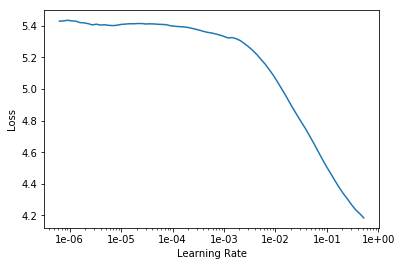

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.479389,3.065503,0.397718,00:11


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.074980,2.979878,0.407242,00:14
1,2.981348,2.878369,0.419511,00:14
2,2.864376,2.811772,0.425860,00:13
3,2.732771,2.769796,0.430324,00:13
4,2.603176,2.747737,0.432110,00:13
5,2.474990,2.747421,0.433399,00:13
6,2.371657,2.751906,0.433201,00:14
7,2.296485,2.760792,0.432970,00:14
8,2.230669,2.767833,0.433366,00:14
9,2.201564,2.770301,0.433995,00:13


In [0]:
learn.save('fine_tuned')

In [0]:
TEXT = "The"
N_WORDS = 100
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The trains are going to look like they were .... But i 've got a big glass table . Ok . So good . Where are you ? . The back carriage . i 'll come to you . Do you want to come to Tooting . i 'm in Waterloo . Where are you . Car . Just picked up my pass . Coming . Can you get some tissue ? . i 'm getting the bottle . You can come and get me
The best way with this guy is when i 'm the other 2 . You did n't say goodbye to me . i did n't say goodbye to you . Yes . You 're going to be back so late . It 's ok . How about you ? . i 'm at the flat . Oh . Well done . The train is delayed . Are you nearly here . Do n't be late . What are you doing . So late . Are you here .
